# **Forecasting Seasonal Time Series Data using Bidirectional LSTM Networks**

In this project, we explore time series forecasting using TensorFlow's sequence modeling tools, focusing on Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) layers. These architectures are well-suited for capturing patterns in sequential data, making them ideal for forecasting tasks where temporal dependencies are important.

We'll walk through the process of preparing data, building bidirectional LSTM models, and evaluating their forecasting performance on seasonal time series data.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [ ]:
import unittests

## Generating the data

Let's begin by defining a bunch of helper functions to generate and plot the time series:

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    """Plot the series"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    """A trend over time"""
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    """Adds noise to the series"""
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

These are the same we have been using in the previous assignments, so we will be generating the same time series data. We can do that with the following function:

In [ ]:
def generate_time_series():
    """ Creates timestamps and values of the time series """

    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)

    return time, series

## Defining some useful global variables

Next, we will define some global variables that will be used throughout the assignment. Feel free to reference them in the upcoming exercises:

`SPLIT_TIME`: time index to split between train and validation sets

`WINDOW_SIZE`: length od the window to use for smoothing the series

`BATCH_SIZE`: batch size for training the model

`SHUFFLE_BUFFER_SIZE`: number of elements from the dataset used to sample for a new shuffle of the dataset. For more information about the use of this variable we can take a look at the [docs](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle).


In [ ]:
SPLIT_TIME = 1100
WINDOW_SIZE = 20
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

Finally, put everything together and create the times series we will use for this assignment. We will save them in the global variables `TIME` and `SERIES`.

In [ ]:
# Create the time series
TIME, SERIES = generate_time_series()

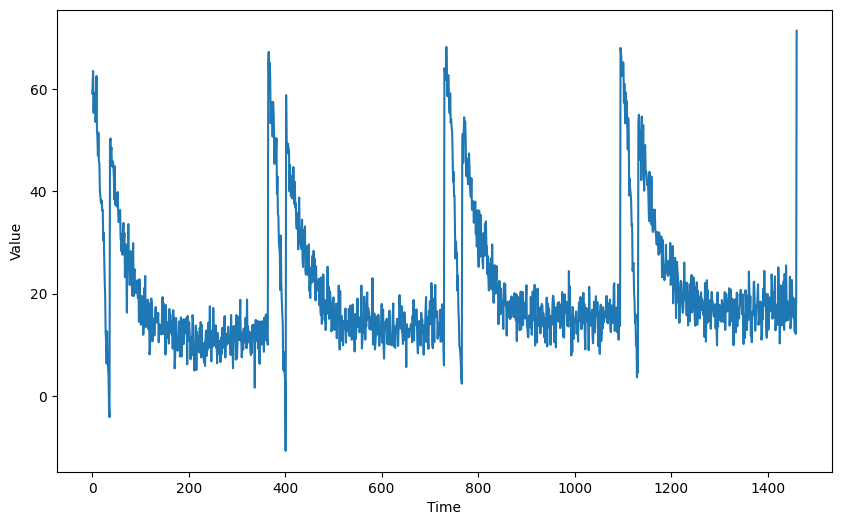

In [ ]:
# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(TIME, SERIES)
plt.show()

## Processing the data

Since we already coded the `train_val_split` and `windowed_dataset` functions during past week's assignments, this time they are provided for we. Notice that in `windowed_dataset` an extra step is added which expands the series to have an extra dimension. This is done because we will be working with RNN-like layers which expect the dimensionality of its inputs to be 3 (including the batch dimension). In the previous weeks we used simple Dense layers which don't have this requirement.


In [ ]:
def train_val_split(time, series):
    """ Splits time series into train and validation sets"""
    time_train = time[:SPLIT_TIME]
    series_train = series[:SPLIT_TIME]
    time_valid = time[SPLIT_TIME:]
    series_valid = series[SPLIT_TIME:]

    return time_train, series_train, time_valid, series_valid

In [ ]:
def windowed_dataset(series, window_size):
    """Creates windowed dataset"""
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(BATCH_SIZE).prefetch(1)
    return dataset

Now, run the cell below to call these two functions and generate our training dataset:

In [ ]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)
# Apply the transformation to the training set
dataset = windowed_dataset(series_train, WINDOW_SIZE)

## Defining the model architecture

### Exercise 1: create_uncompiled_model

Now that we have a function that will process the data before it is fed into our neural network for training, it is time to define our layer architecture.

In previous weeks or courses we defined our layers and compiled the model in the same function. However, here we will do thing a little bit different: we will first define the `create_uncompiled_model` function, which only determines our model's structure, and later on we will compile it. This way we can can reuse our model's layers for the learning rate adjusting and the actual training.

Remember that, as we saw on the lectures, there are a couple of layers we will need to add. Firstly, since LSTM and RNN layers expect three dimensions for the input (`batch_size`, `window_size`, `series_dimensionality`), and we have just a univariate time series, we will need to account for this, which can be done via the `tf.keras.Input` (this is already provided for we). Also, it is a good practice to add a layer at the end to make the output values, which are between -1 and 1 for the tanh activation function, be of the same order as the actual values of the series.

Hint:
- We should use `SimpleRNN` or `Bidirectional(LSTM)` as intermediate layers.

- The last layer of the network (before the last `Lambda`) should be a `Dense` layer.
- Fill in the `Lambda` layer at the end of the network with the correct lambda function.

In [ ]:
def create_uncompiled_model():
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(WINDOW_SIZE, 1)),

        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),

        tf.keras.layers.Dense(1),

        tf.keras.layers.Lambda(lambda x: x * 100.0)  # Adjust scaling factor as needed
    ])

    return model

The next cell allows we to check the number of total and trainable parameters of our model and prompts a warning in case these exceeds those of a reference solution, this serves the following 3 purposes listed in order of priority:

- Helps we prevent crashing the kernel during training.

- Helps we avoid longer-than-necessary training times.

- Provides a reasonable estimate of the size of our model. In general we will usually prefer smaller models given that they accomplish their goal successfully.


In [ ]:
# Define your uncompiled model
uncompiled_model = create_uncompiled_model()

# Check the parameter count against a reference solution
unittests.parameter_count(uncompiled_model)

Your model has 8,769 total parameters and the reference is 35,000. You are good to go!

Your model has 8,769 trainable parameters and the reference is 35,000. You are good to go!


In [ ]:
example_batch = dataset.take(1)

try:
	predictions = uncompiled_model.predict(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	print("Your current architecture is compatible with the windowed dataset! :)")
	print(f"predictions have shape: {predictions.shape}")

Your current architecture is compatible with the windowed dataset! :)
predictions have shape: (32, 1)


**Expected output:**

```
Your current architecture is compatible with the windowed dataset! :)
predictions have shape: (NUM_BATCHES, 1)
```
Where `NUM_BATCHES` is the number of batches we have set to our dataset.

In [ ]:
# Test your code!
unittests.test_create_uncompiled_model(create_uncompiled_model)

 All tests passed!


As a last check, we can also print a summary of our model to see what the architecture looks like. This can be useful to get a sense of how big our model is.

In [ ]:
uncompiled_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 64)             │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,769 (34.25 KB)

 Trainable params: 8,769 (34.25 KB)

 Non-trainable params: 0 (0.00 B)

## Adjusting the learning rate

As we saw in the lectures we can leverage Tensorflow's callbacks to dinamically vary the learning rate during training. This can be helpful to get a better sense of which learning rate better acommodates to the problem at hand.

**Notice that this is only changing the learning rate during the training process to give we an idea of what a reasonable learning rate is and should not be confused with selecting the best learning rate, this is known as hyperparameter optimization and it is outside the scope of this course.**

For the optimizers we can try out:
- [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
- [`tf.keras.optimizers.SGD`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) with a momentum of 0.9

In [ ]:
def adjust_learning_rate(model):
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))

    optimizer = tf.keras.optimizers.Adam()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

    return history

lr_history = adjust_learning_rate(uncompiled_model)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 73.2554 - mae: 73.7554 - learning_rate: 1.0000e-06
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 72.5885 - mae: 73.0885 - learning_rate: 1.1220e-06
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 71.7866 - mae: 72.2866 - learning_rate: 1.2589e-06
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 72.1359 - mae: 72.6359 - learning_rate: 1.4125e-06
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 71.5598 - mae: 72.0598 - learning_rate: 1.5849e-06
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 72.1336 - mae: 72.6336 - learning_rate: 1.7783e-06
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 70.6524 - mae: 71.1524 - learning_rate: 1.9953e-06
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 69.8793 - mae: 70.3793 - learning_rate: 2.2387e-06
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 69.6872 - mae: 70.1872 - learning_rate: 2.5119e-06
Epoch 10/1

In [ ]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(uncompiled_model)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.4728 - mae: 3.9439 - learning_rate: 1.0000e-06
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3948 - mae: 3.8655 - learning_rate: 1.1220e-06
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3795 - mae: 3.8501 - learning_rate: 1.2589e-06
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2282 - mae: 3.6959 - learning_rate: 1.4125e-06
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2678 - mae: 3.7370 - learning_rate: 1.5849e-06
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4002 - mae: 3.8694 - learning_rate: 1.7783e-06
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3050 - mae: 3.7700 - learning_rate: 1.9953e-06
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2373 - mae: 3.7012 - learning_rate: 2.2387e-06
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2514 - mae: 3.7184 - learning_rate: 2.5119e-06
Epoch 10/100
34/34 ━━━━━━━━━

Plot the achieved loss for each learning rate value, this way we can select an appropriate learning rate for our training.

(1e-06, 1.0, 0.0, 30.0)

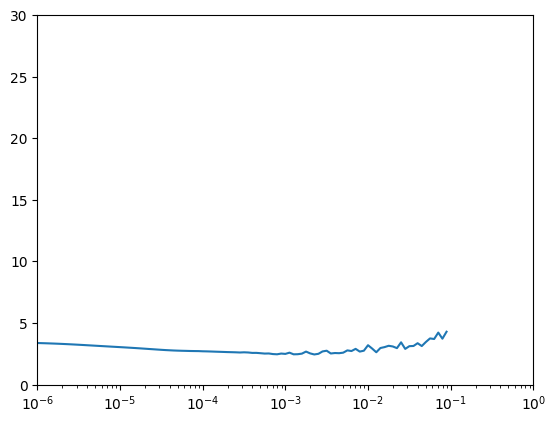

In [ ]:
# Plot the loss for every LR
plt.semilogx(lr_history.history["learning_rate"], lr_history.history["loss"])
plt.axis([1e-6, 1, 0, 30])

## Compiling the model

### Exercise 2: create_model

Now it is time to do the actual training that will be used to forecast the time series. For this complete the `create_model` function below.

Notice that we are reusing the architecture we defined in the `create_uncompiled_model` earlier. Now we only need to compile this model using the appropriate loss, optimizer (and learning rate). If we completed the previous optional exercise, we should have a pretty good idea of which combinations might work better.

In [ ]:
def create_model():
    model = create_uncompiled_model()

    optimizer = tf.keras.optimizers.Adam()

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=optimizer,
                  metrics=["mae"])

    return model

In [ ]:
# Create an instance of the model
model = create_model()

In [ ]:
# Test your code!
unittests.test_create_model(create_model)

 All tests passed!


Let’s begin training the model:

In [ ]:
# Train it
history = model.fit(dataset, epochs=50)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 213.0066 - mae: 11.1364
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 54.3520 - mae: 5.0037
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 42.9873 - mae: 4.4522
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27.0791 - mae: 3.7094
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.4179 - mae: 3.3248
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25.0937 - mae: 3.2820
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 30.1700 - mae: 3.3705
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.1205 - mae: 3.0036
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.8580 - mae: 3.2040
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27.6391 - mae: 3.1897
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.6825 - mae: 3.0151
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.8594 - mae: 3.0814
Epoch 13/50
34/34 ━━━━━━━━━━━━━━━━━

Plotting the training loss helps monitor the model’s learning progress and identify potential issues such as underfitting or overfitting.

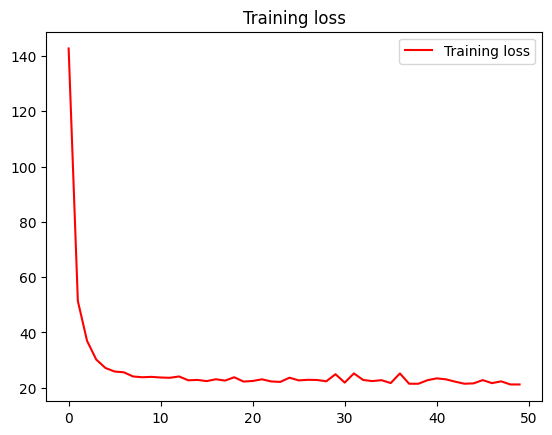

In [ ]:
# Plot the training loss for each epoch

loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.show()

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this we can use the `compute_metrics` function:

In [ ]:
def compute_metrics(true_series, forecast):
    """Computes MSE and MAE metrics for the forecast"""
    mse = tf.keras.losses.MSE(true_series, forecast)
    mae = tf.keras.losses.MAE(true_series, forecast)
    return mse, mae

At this point we have trained the model that will perform the forecast, but we still need to compute the actual forecast. For this, we will use the `generate_forecast` function. This function, which is the same we used on previous assignments, generates the next value given a set of the previous `window_size` points for every point in the validation set.

In [ ]:
def generate_forecast(model, series, window_size):
    """Generates a forecast using your trained model"""
    forecast = []
    for time in range(SPLIT_TIME, len(series)):
        pred = model.predict(series[time-window_size:time][np.newaxis])
        forecast.append(pred[0][0])
    return forecast

The following section produces forecasts using the trained model and visualizes them alongside the actual time series data to evaluate performance.

In [ ]:
# Save the forecast
rnn_forecast = generate_forecast(model, SERIES, WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

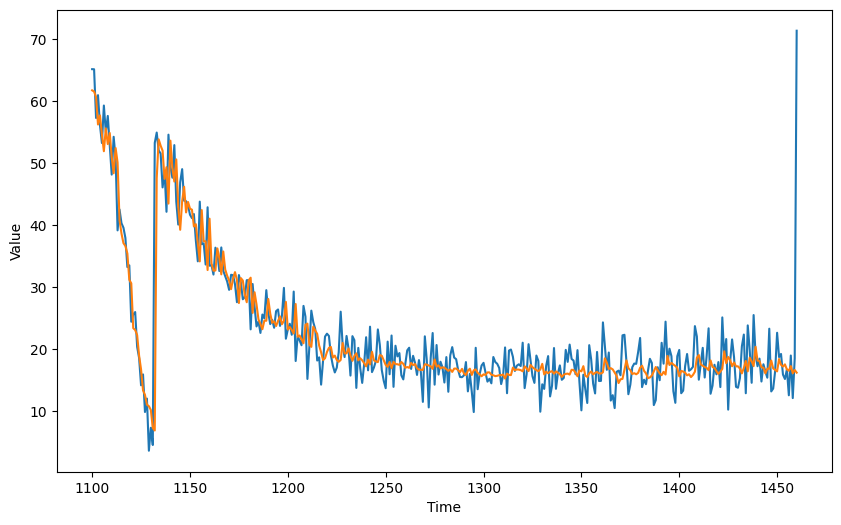

In [ ]:
# Plot your forecast
plt.figure(figsize=(10, 6))

plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

Now use the `compute_metrics function` to find the MSE and MAE of our forecast.

In [ ]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 27.04, mae: 3.07 for forecast


In [ ]:
# Save your mae in a pickle file
with open('forecast_mae.pkl', 'wb') as f:
    pickle.dump(mae.numpy(), f)